In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.preprocessing import StandardScaler

### Data load 

In [71]:
# Data
df = pd.read_csv('../data/df.csv')

### Data exploration

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df.head()

,customer_id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


### Preprocessing

In [73]:
def convert_dataframe(df):
    # Reemplazar valores en blanco o espacios vacíos con NaN
    df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

    # Convertir columnas binarias
    df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})
    df['Partner'] = df['Partner'].map({'No': 0, 'Yes': 1})
    df['Dependents'] = df['Dependents'].map({'No': 0, 'Yes': 1})
    df['PhoneService'] = df['PhoneService'].map({'No': 0, 'Yes': 1})
    df['MultipleLines'] = df['MultipleLines'].map({'No': 0, 'Yes': 1, 'No phone service': 2})
    df['OnlineSecurity'] = df['OnlineSecurity'].map({'No': 0, 'Yes': 1, 'No internet service': 2})
    df['OnlineBackup'] = df['OnlineBackup'].map({'No': 0, 'Yes': 1, 'No internet service': 2})
    df['DeviceProtection'] = df['DeviceProtection'].map({'No': 0, 'Yes': 1, 'No internet service': 2})
    df['TechSupport'] = df['TechSupport'].map({'No': 0, 'Yes': 1, 'No internet service': 2})
    df['StreamingTV'] = df['StreamingTV'].map({'No': 0, 'Yes': 1, 'No internet service': 2})
    df['StreamingMovies'] = df['StreamingMovies'].map({'No': 0, 'Yes': 1, 'No internet service': 2})
    df['PaperlessBilling'] = df['PaperlessBilling'].map({'No': 0, 'Yes': 1})
    df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

    # Convertir columnas categóricas con One-Hot Encoding
    df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'])

    # Eliminar columnas no numéricas o innecesarias
    df = df.drop(columns=['customer_id'])

    # Asegurarse de que todas las columnas sean numéricas
    df = df.apply(pd.to_numeric, errors='coerce')

    # Eliminar filas con valores NaN
    df.dropna(inplace=True)

    return df

# Cargar el dataframe completo
df = pd.read_csv('../data/df.csv') 

# Convertir los datos (limpiar y transformar)
df_final = convert_dataframe(df)

In [74]:
# Balance
churn_counts = df_final['Churn'].value_counts()
churn_counts

Churn
0    5163
1    1869
Name: count, dtype: int64

In [75]:
# Dividir en Train y Test csv
dftrain, dftest = train_test_split(df_final, test_size=0.2, random_state=42)

# Guardar los dataframes en archivos CSV
dftrain.to_csv('../data/train/train.csv', index=False)
dftest.to_csv('../data/test/test.csv', index=False)

In [36]:
print(dftrain.columns)

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')


### Análisis

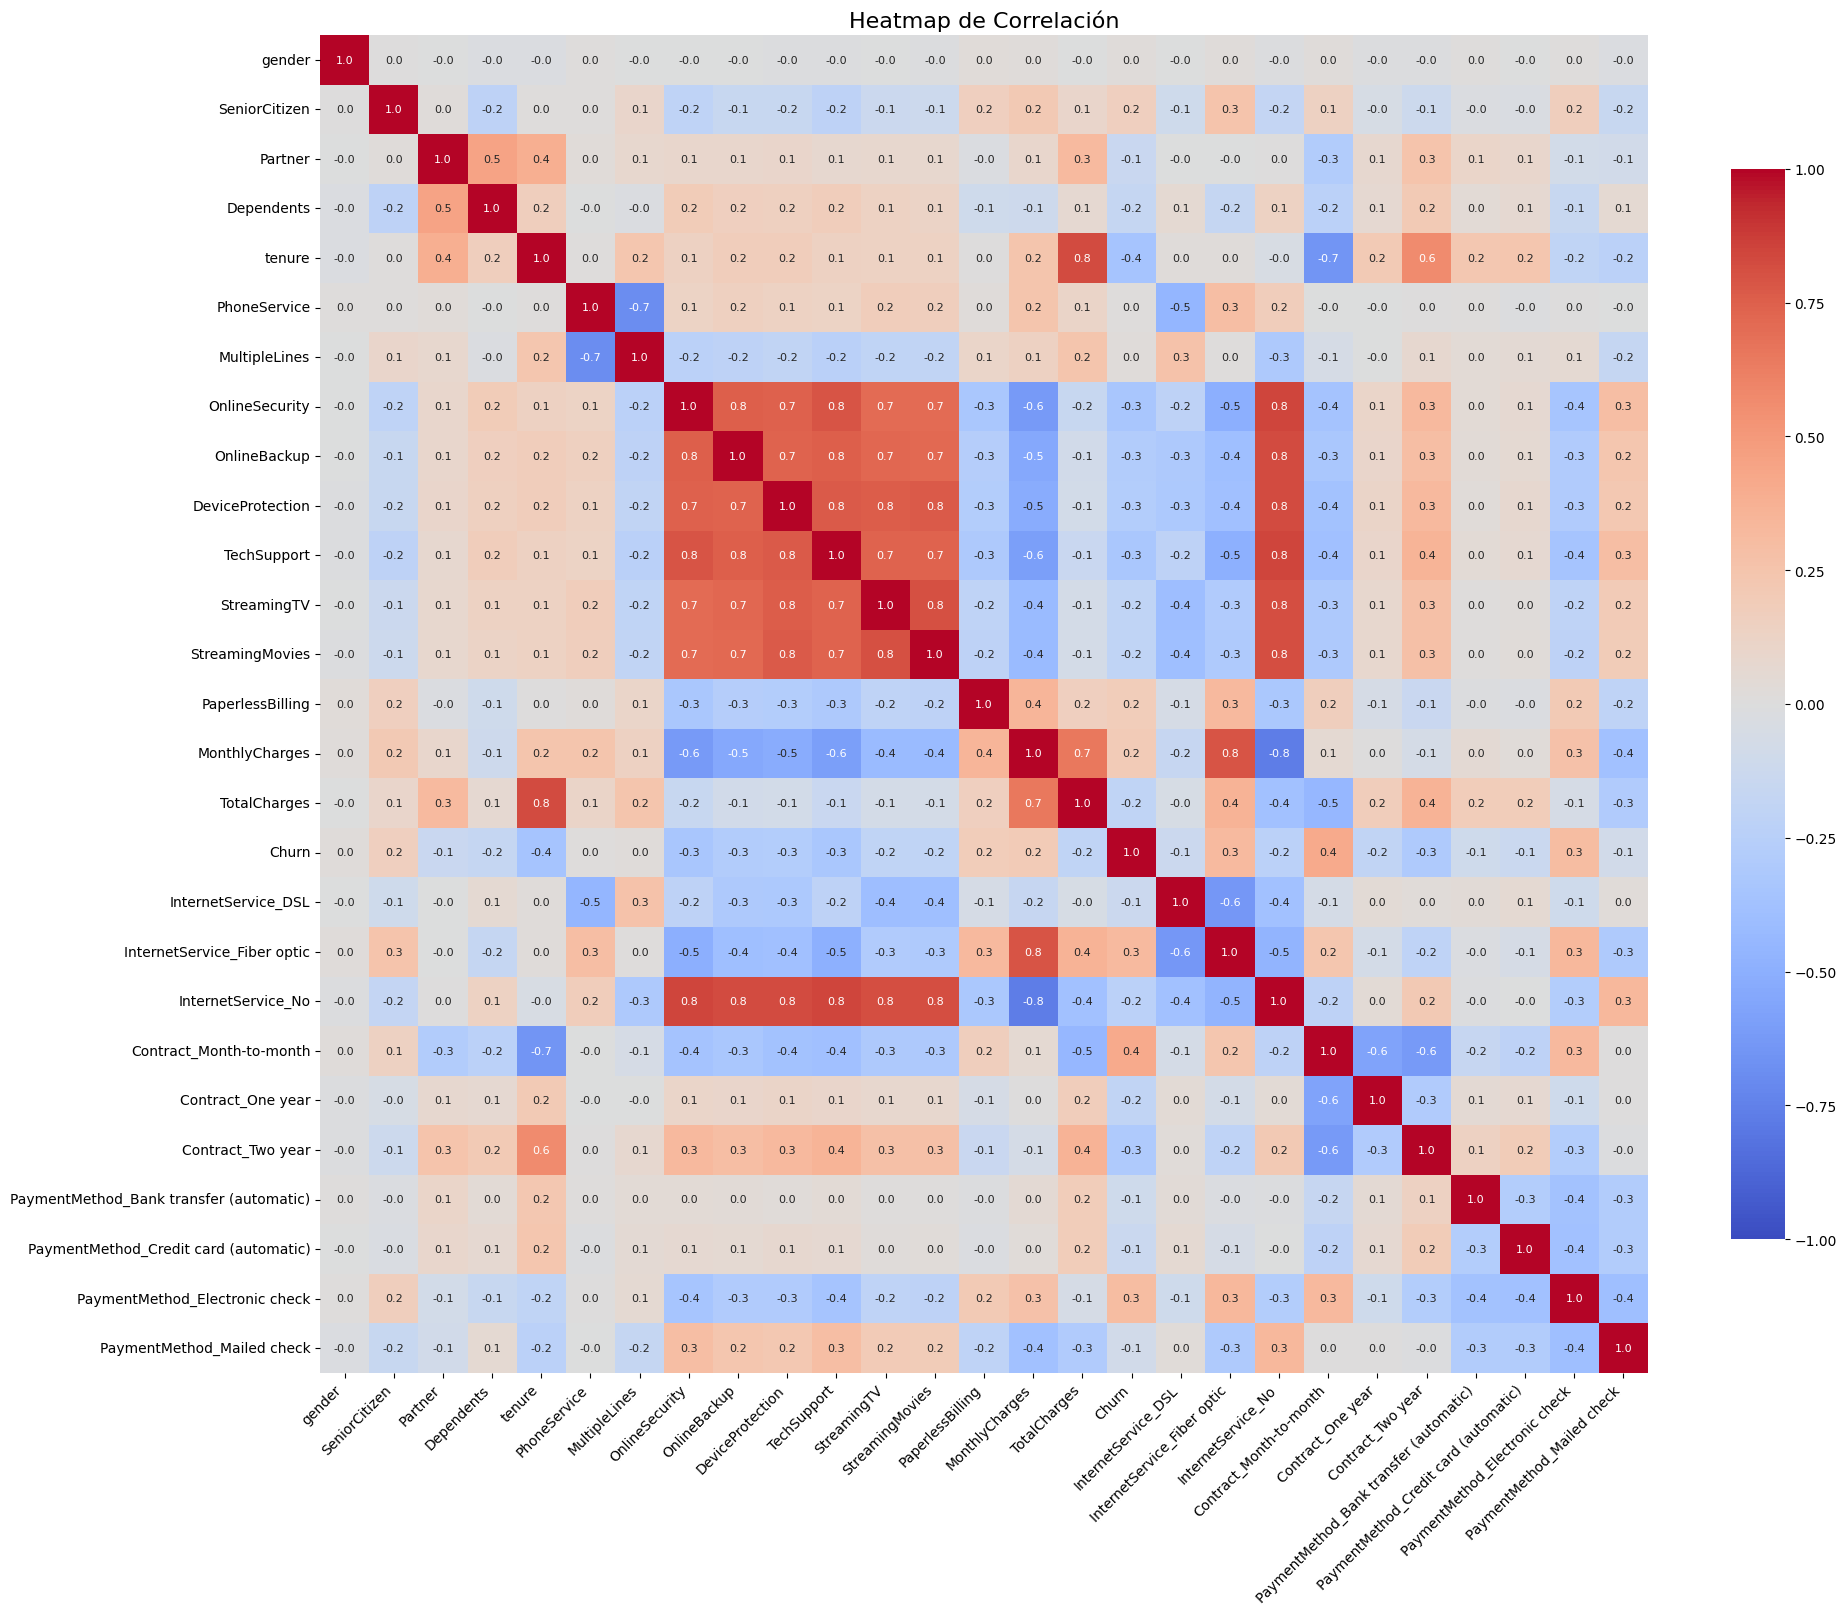

In [100]:
# Calcular la matriz de correlación
corr_matrix = dftrain.corr()

# Configurar el tamaño de la figura
plt.figure(figsize=(20, 16))

# Generar el heatmap de correlación
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.1f', vmin=-1, vmax=1,
            annot_kws={"size": 8}, cbar_kws={"shrink": .8})

# Rotar las etiquetas para una mejor legibilidad
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
# Ajustar el diseño para una mejor visibilidad
plt.tight_layout()

plt.title('Heatmap de Correlación', fontsize=16)
plt.show()

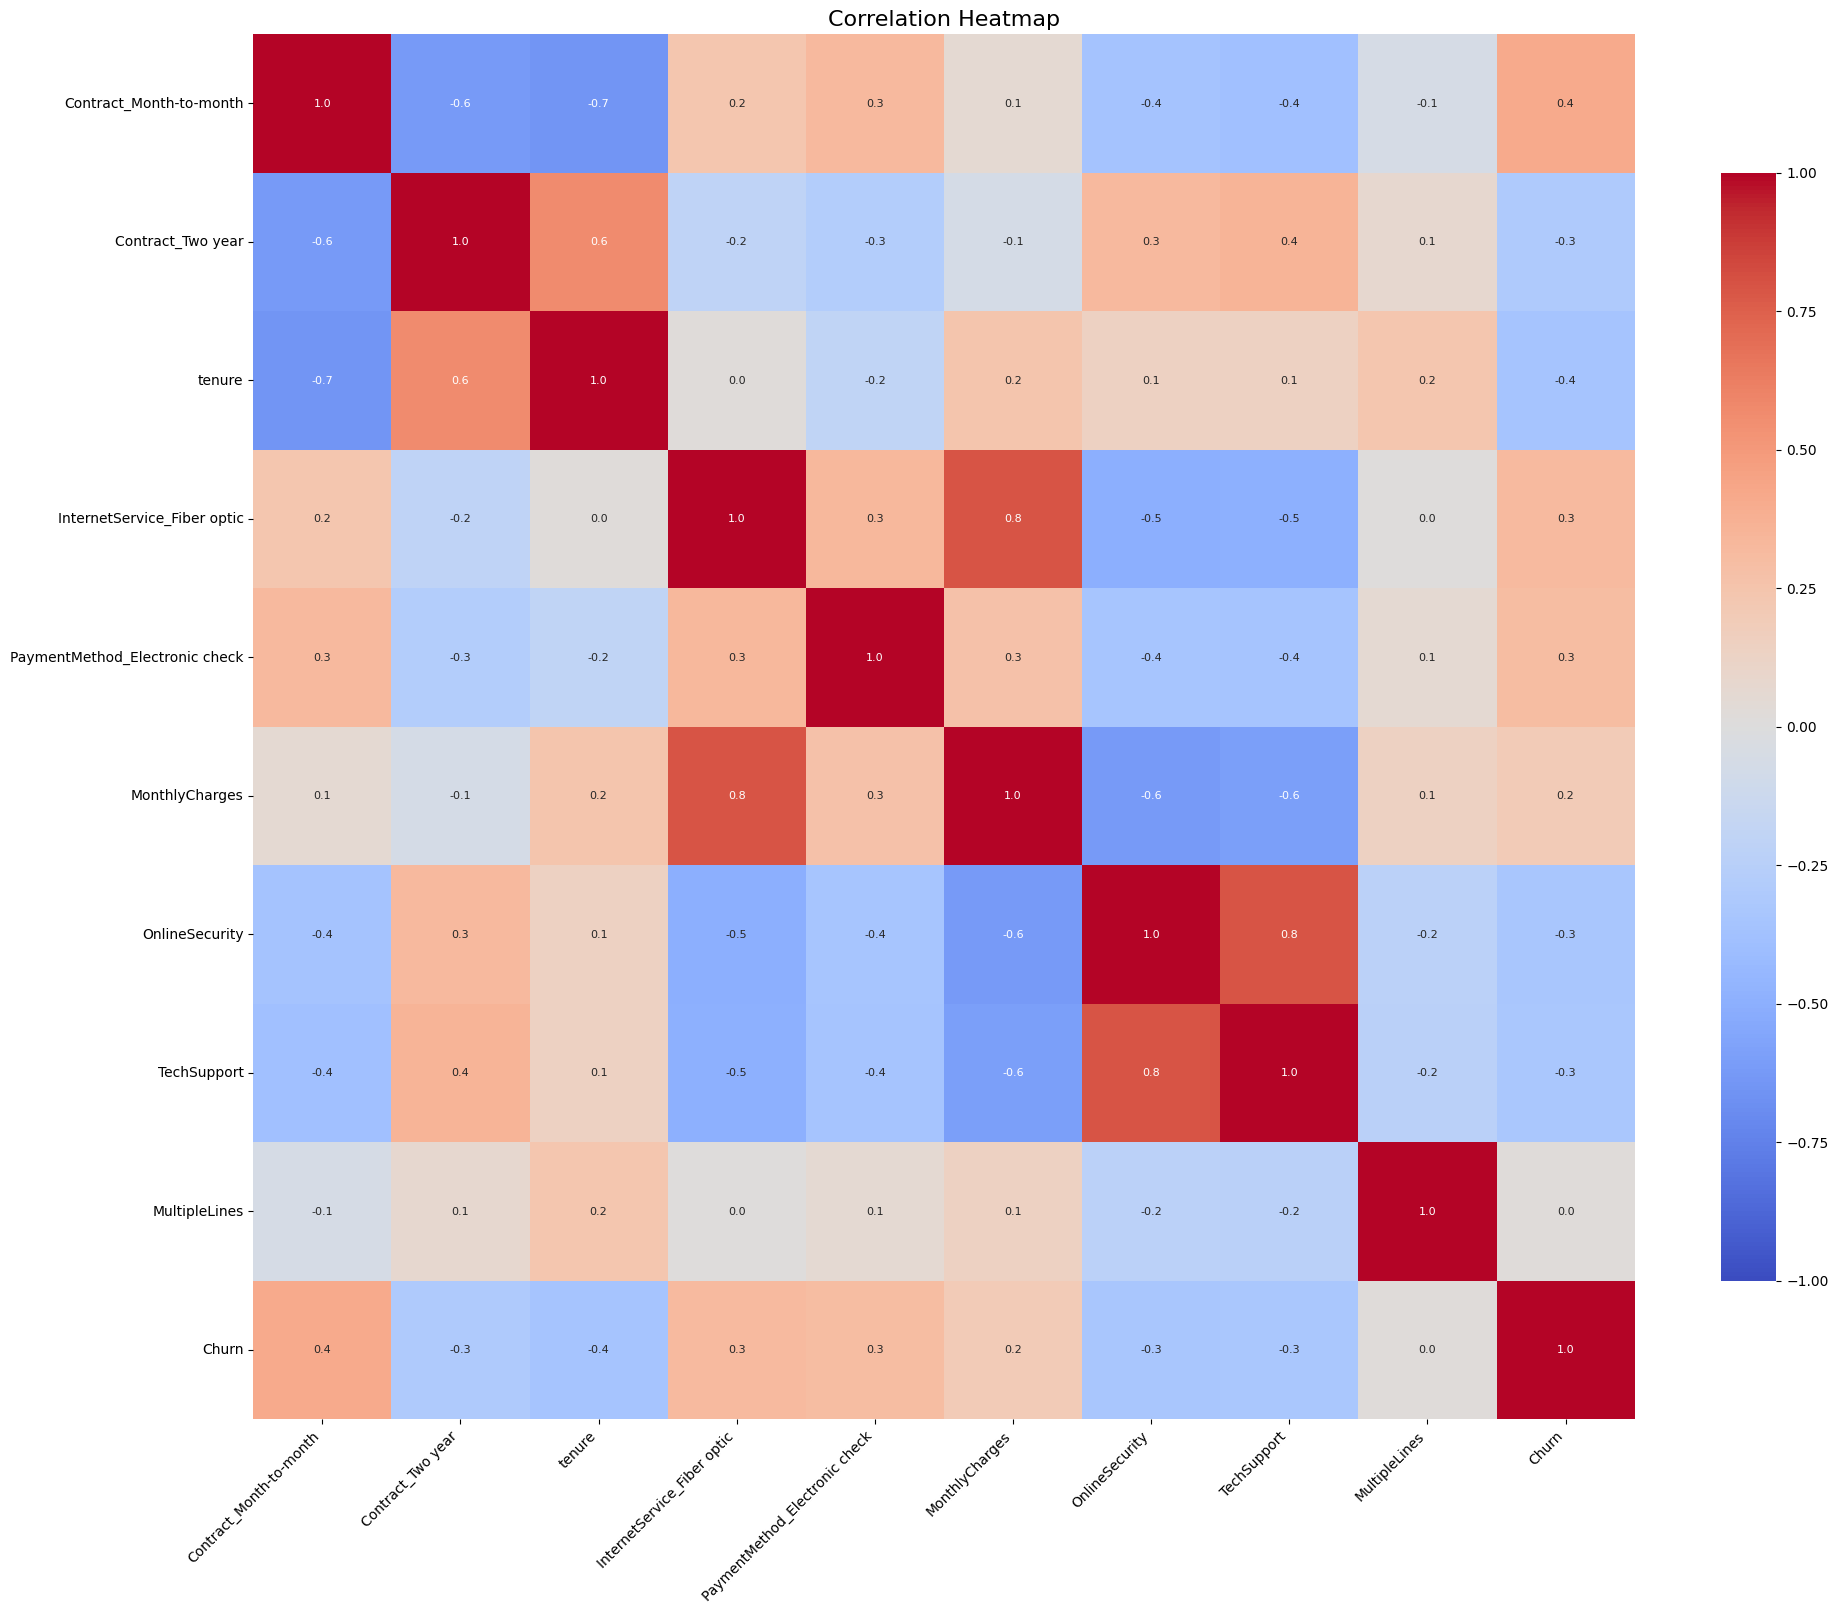

In [101]:
# Seleccionar las variables para el mapa de correlación
X_train = dftrain[['Contract_Month-to-month', 'Contract_Two year', 'tenure', 'InternetService_Fiber optic', 
                   'PaymentMethod_Electronic check', 'MonthlyCharges', 'OnlineSecurity', 
                   'TechSupport', 'MultipleLines', 'Churn']]
y_train = dftrain['Churn']

# Calcular la matriz de correlación
corr_matrix = X_train.corr()

# Configurar el tamaño de la figura
plt.figure(figsize=(20, 16))

# Generar el heatmap de correlación
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.1f', vmin=-1, vmax=1,
            annot_kws={"size": 8}, cbar_kws={"shrink": .8})

# Rotar las etiquetas para una mejor legibilidad
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
# Ajustar el diseño para una mejor visibilidad
plt.tight_layout()

plt.title('Correlation Heatmap', fontsize=16)
plt.show()

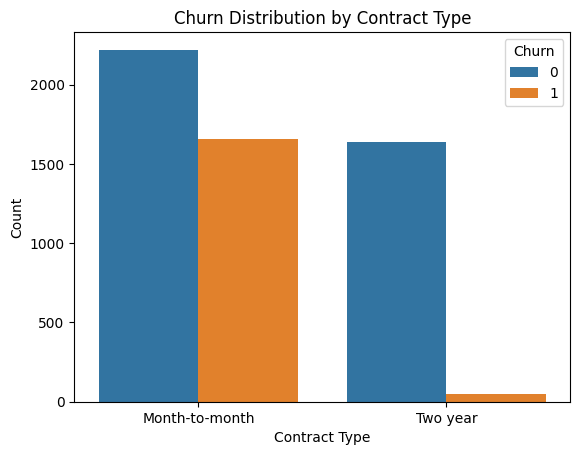

In [78]:
# Crear una nueva columna 'Contract' basada en las columnas One-Hot Encoded para Month-to-month y Two year
df_final['Contract'] = df_final.apply(
    lambda row: 'Month-to-month' if row['Contract_Month-to-month'] == 1 else ('Two year' if row['Contract_Two year'] == 1 else 'Other'),
    axis=1
)

# Filtrar solo Month-to-month y Two year
df_filtered = df_final[df_final['Contract'].isin(['Month-to-month', 'Two year'])]

# Gráfico
sns.countplot(x='Contract', hue='Churn', data=df_filtered)
plt.title('Churn Distribution by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.show()

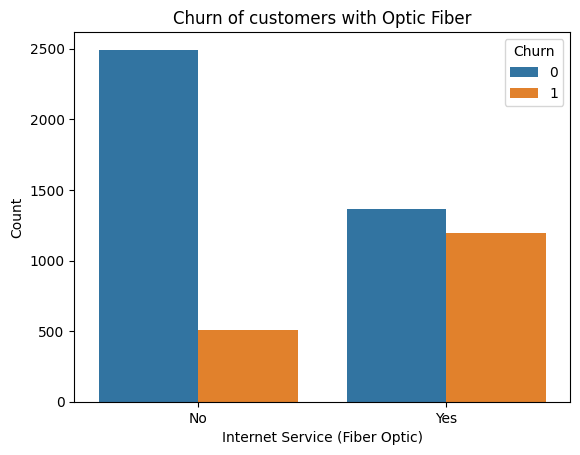

In [79]:
# Gráfico de barras para InternetService_Fiber optic
sns.countplot(x='InternetService_Fiber optic', hue='Churn', data=df_filtered)
plt.title('Churn of customers with Optic Fiber')
plt.xlabel('Internet Service (Fiber Optic)')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'])  # Asumiendo que los valores son 0 y 1
plt.show()

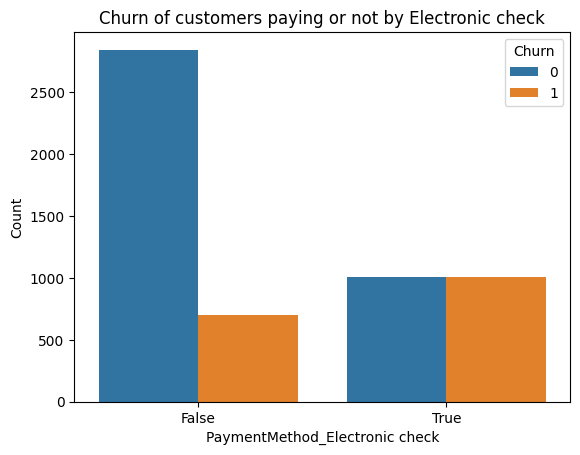

In [80]:
# Gráfico de barras para PaymentMethod
sns.countplot(x='PaymentMethod_Electronic check', hue='Churn', data=df_filtered)
plt.title('Churn of customers paying or not by Electronic check')
plt.xlabel('PaymentMethod_Electronic check')
plt.ylabel('Count')
plt.show()

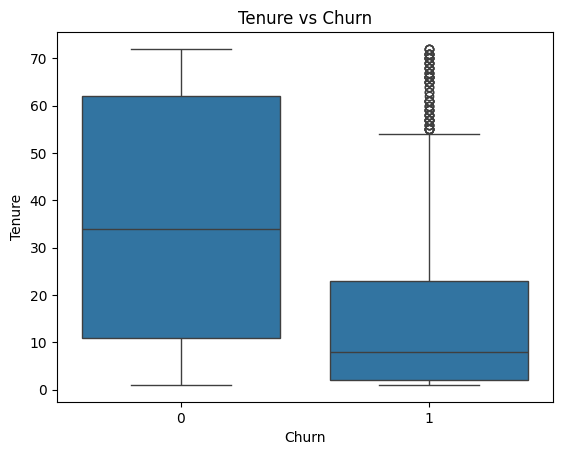

In [81]:
# Boxplot para tenure
sns.boxplot(x='Churn', y='tenure', data=df_filtered)
plt.title('Tenure vs Churn')
plt.xlabel('Churn')
plt.ylabel('Tenure')
plt.show()

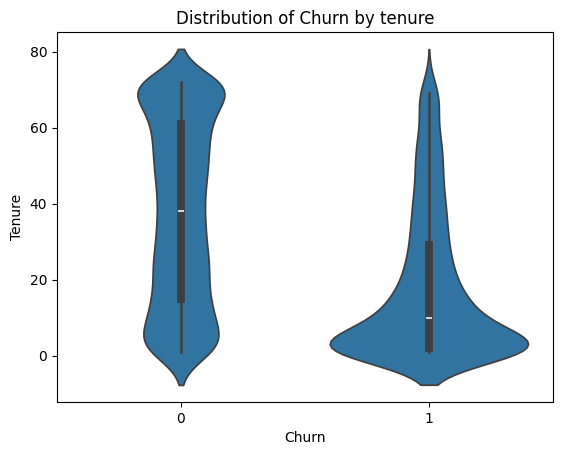

In [82]:
# Gráfica de violín para tenure
sns.violinplot(x='Churn', y='tenure', data=df_final)
plt.title('Distribution of Churn by tenure')
plt.xlabel('Churn')
plt.ylabel('Tenure')
plt.show()

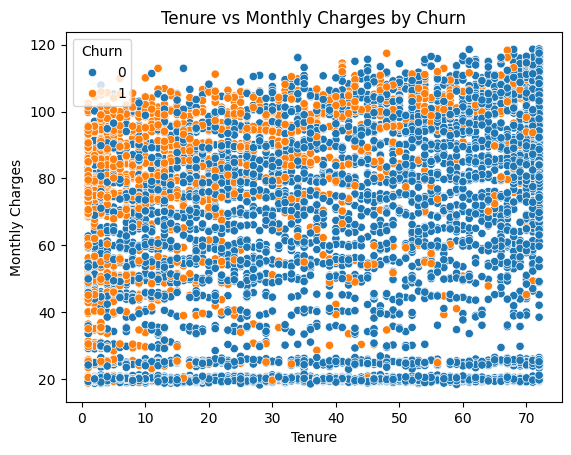

In [83]:
# Gráfica de dispersión para Tenure y MonthlyCharges
sns.scatterplot(x='tenure', y='MonthlyCharges', hue='Churn', data=df_final)
plt.title('Tenure vs Monthly Charges by Churn')
plt.xlabel('Tenure')
plt.ylabel('Monthly Charges')
plt.show()

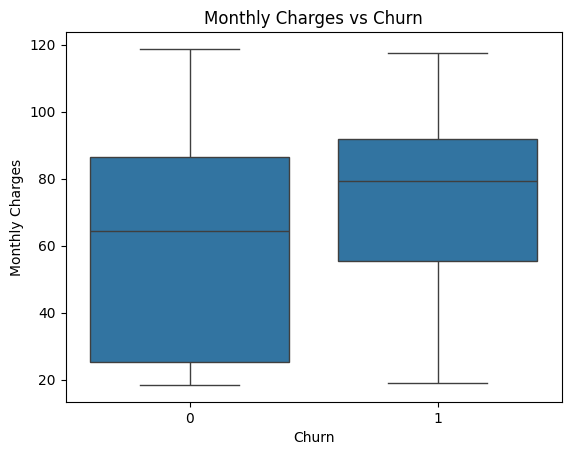

In [84]:
# Boxplot para MonthlyCharges
sns.boxplot(x='Churn', y='MonthlyCharges', data=df_filtered)
plt.title('Monthly Charges vs Churn')
plt.xlabel('Churn')
plt.ylabel('Monthly Charges')
plt.show()

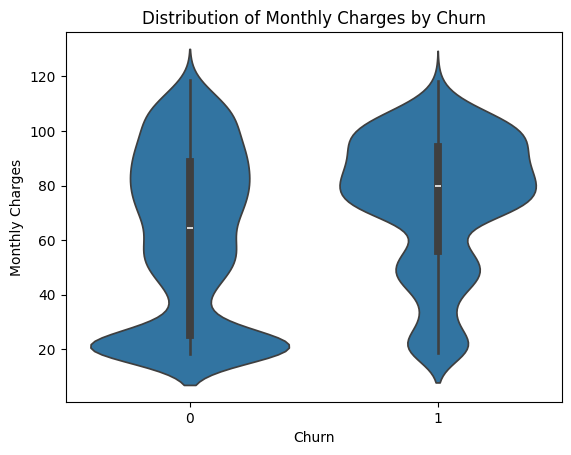

In [85]:
# Gráfica de violín para MonthlyCharges
sns.violinplot(x='Churn', y='MonthlyCharges', data=df_final)
plt.title('Distribution of Monthly Charges by Churn')
plt.xlabel('Churn')
plt.ylabel('Monthly Charges')
plt.show()

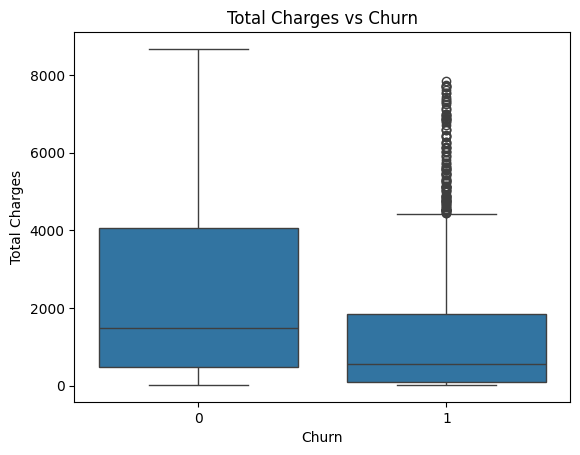

In [86]:
# Boxplot para TotalCharges
sns.boxplot(x='Churn', y='TotalCharges', data=df_filtered)
plt.title('Total Charges vs Churn')
plt.xlabel('Churn')
plt.ylabel('Total Charges')
plt.show()

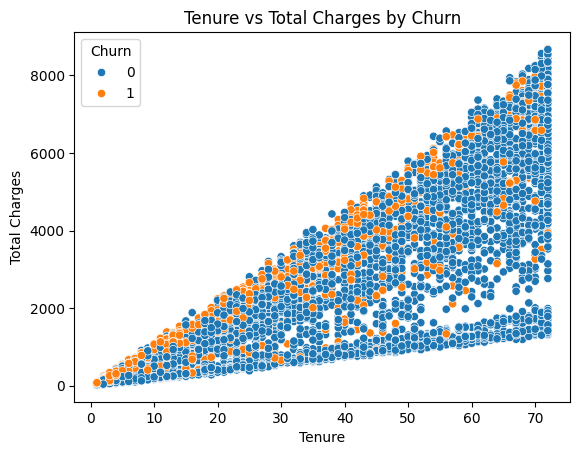

In [87]:
# Gráfica de dispersión para Tenure y TotalCharges
sns.scatterplot(x='tenure', y='TotalCharges', hue='Churn', data=df_final)
plt.title('Tenure vs Total Charges by Churn')
plt.xlabel('Tenure')
plt.ylabel('Total Charges')
plt.show()

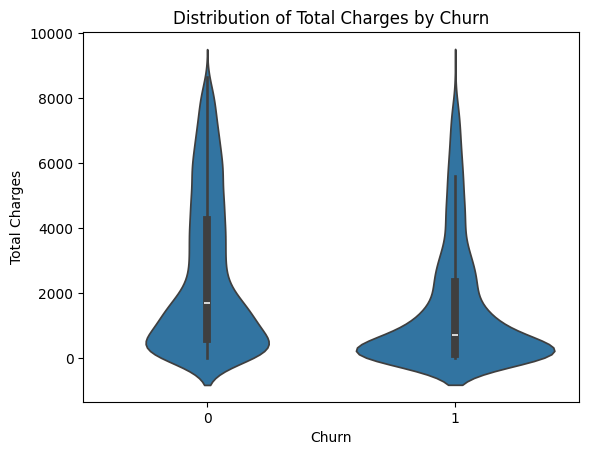

In [88]:
# Gráfica de violín para TotalCharges
sns.violinplot(x='Churn', y='TotalCharges', data=df_final)
plt.title('Distribution of Total Charges by Churn')
plt.xlabel('Churn')
plt.ylabel('Total Charges')
plt.show()

# MODELOS 

In [90]:
# Separar cvariables predictoras y variable objetivo
#X_train = dftrain.drop('Churn', axis=1) MEJOR OPCION POR EL MOMENTO
#X_train = dftrain[['Contract_Month-to-month', 'Contract_Two year', 'Contract_One year', 'tenure']]# ACCURACY 0.75, PRECISION 0.79, RECALL: 0.90(GBC)
#X_train = dftrain[['Contract_Month-to-month', 'Contract_Two year', 'Contract_One year', 'tenure', 'InternetService_Fiber optic', 'PaymentMethod_Electronic check', 'MonthlyCharges', 'TotalCharges']]# ACCURACY 0.78, PRECISION 0.83, RECALL: 0.89(GBC)
#X_train = dftrain[['Contract_Month-to-month', 'Contract_Two year', 'Contract_One year', 'tenure', 'InternetService_Fiber optic', 'PaymentMethod_Electronic check', 'MonthlyCharges', 'TotalCharges',  'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Dependents', 'Partner']]# ACCURACY 0.79, PRECISION 0.82, RECALL: 0.90(GBC)
#y_train = dftrain['Churn']
#X_test = dftest[['Contract_Month-to-month', 'Contract_Two year', 'Contract_One year', 'tenure']]# ACCURACY 0.75, PRECISION 0.79, RECALL: 0.90(GBC)
#X_test = dftest[['Contract_Month-to-month', 'Contract_Two year', 'Contract_One year', 'tenure', 'InternetService_Fiber optic', 'PaymentMethod_Electronic check', 'MonthlyCharges', 'TotalCharges']]# ACCURACY 0.78, PRECISION 0.83, RECALL: 0.89(GBC)
#X_test = dftest[['Contract_Month-to-month', 'Contract_Two year', 'Contract_One year', 'tenure', 'InternetService_Fiber optic', 'PaymentMethod_Electronic check', 'MonthlyCharges', 'TotalCharges',  'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Dependents', 'Partner']]# ACCURACY 0.79, PRECISION 0.82, RECALL: 0.90(GBC)
#y_test = dftest['Churn']

X_train = dftrain[['Contract_Month-to-month', 'Contract_Two year', 'tenure', 'InternetService_Fiber optic', 'PaymentMethod_Electronic check', 'MonthlyCharges', 'OnlineSecurity', 'TechSupport', 'MultipleLines']]# ACCURACY 0.79, PRECISION 0.83, RECALL: 0.91(GBC)
y_train = dftrain['Churn']
X_test = dftest[['Contract_Month-to-month', 'Contract_Two year', 'tenure', 'InternetService_Fiber optic', 'PaymentMethod_Electronic check', 'MonthlyCharges', 'OnlineSecurity', 'TechSupport', 'MultipleLines']]# ACCURACY 0.79, PRECISION 0.83, RECALL: 0.91(GBC)
y_test = dftest['Churn']

### Prueba Modelos Supervisados

In [91]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Crear y entrenar el modelo
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_dt = dt_model.predict(X_test)

# Evaluar el modelo
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 0.7334754797441365
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82      1033
           1       0.50      0.50      0.50       374

    accuracy                           0.73      1407
   macro avg       0.66      0.66      0.66      1407
weighted avg       0.73      0.73      0.73      1407



In [92]:
# Decision Tree con Pipeline de Normalización y Balanceo
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

# Cargar los dataframes desde archivos CSV
dftrain = pd.read_csv('../data/train/train.csv')
dftest = pd.read_csv('../data/test/test.csv')

# Separar variables predictoras y variable objetivo
X_train = dftrain[['Contract_Month-to-month', 'Contract_Two year', 'tenure', 'InternetService_Fiber optic',
                   'PaymentMethod_Electronic check', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity',
                   'TechSupport', 'MultipleLines']]
y_train = dftrain['Churn']
X_test = dftest[['Contract_Month-to-month', 'Contract_Two year', 'tenure', 'InternetService_Fiber optic',
                 'PaymentMethod_Electronic check', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity',
                 'TechSupport', 'MultipleLines']]
y_test = dftest['Churn']

# Crear y entrenar el modelo
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Evaluar el modelo
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred))
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred))

Decision Tree Accuracy: 0.7192608386638237
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.77      0.80      1033
           1       0.48      0.57      0.52       374

    accuracy                           0.72      1407
   macro avg       0.65      0.67      0.66      1407
weighted avg       0.74      0.72      0.73      1407



In [93]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Crear y entrenar el modelo
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_rf = rf_model.predict(X_test)

# Evaluar el modelo
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.7768301350390903
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85      1033
           1       0.61      0.46      0.52       374

    accuracy                           0.78      1407
   macro avg       0.71      0.68      0.69      1407
weighted avg       0.76      0.78      0.77      1407



In [94]:
# Random Forest con Pipeline de Normalización y Balanceo
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Cargar los dataframes desde archivos CSV
dftrain = pd.read_csv('../data/train/train.csv')
dftest = pd.read_csv('../data/test/test.csv')

# Separar variables predictoras y variable objetivo
X_train = dftrain[['Contract_Month-to-month', 'Contract_Two year', 'tenure', 'InternetService_Fiber optic',
                   'PaymentMethod_Electronic check', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity',
                   'TechSupport', 'MultipleLines']]
y_train = dftrain['Churn']
X_test = dftest[['Contract_Month-to-month', 'Contract_Two year', 'tenure', 'InternetService_Fiber optic',
                 'PaymentMethod_Electronic check', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity',
                 'TechSupport', 'MultipleLines']]
y_test = dftest['Churn']

# Crear y entrenar el modelo
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Evaluar el modelo
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred))


Random Forest Accuracy: 0.7526652452025586
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83      1033
           1       0.53      0.58      0.55       374

    accuracy                           0.75      1407
   macro avg       0.69      0.70      0.69      1407
weighted avg       0.76      0.75      0.76      1407



In [95]:
# Gradient Boosting con Pipeline de Normalización y SIN Balanceo
# Definir el pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalizar los datos
    ('classifier', GradientBoostingClassifier(random_state=42))  # Clasificador
])

# Entrenar el modelo usando el pipeline
pipeline.fit(X_train, y_train)

# Guardar el pipeline completo en un archivo
with open('../models/gbc_pipeline_model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

# Cargar el pipeline completo desde el archivo
with open('../models/gbc_pipeline_model.pkl', 'rb') as f:
    loaded_pipeline = pickle.load(f)

# Predecir en el conjunto de prueba
y_pred = loaded_pipeline.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.86      1033
           1       0.65      0.48      0.55       374

    accuracy                           0.79      1407
   macro avg       0.74      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407



In [96]:
# Gradient Boosting
from xgboost import XGBClassifier

# Crear y entrenar el modelo
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_xgb = xgb_model.predict(X_test)

# Evaluar el modelo
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.7761194029850746
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      1033
           1       0.59      0.50      0.54       374

    accuracy                           0.78      1407
   macro avg       0.71      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:28:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [50]:
# Gradient Boosting con Pipeline de Normalización y Balanceo
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# Cargar los dataframes desde archivos CSV
dftrain = pd.read_csv('../data/train/train.csv')
dftest = pd.read_csv('../data/test/test.csv')

# Separar variables predictoras y variable objetivo
X_train = dftrain[['Contract_Month-to-month', 'Contract_Two year', 'tenure', 'InternetService_Fiber optic',
                   'PaymentMethod_Electronic check', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity',
                   'TechSupport', 'MultipleLines']]
y_train = dftrain['Churn']
X_test = dftest[['Contract_Month-to-month', 'Contract_Two year', 'tenure', 'InternetService_Fiber optic',
                 'PaymentMethod_Electronic check', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity',
                 'TechSupport', 'MultipleLines']]
y_test = dftest['Churn']

# Crear y entrenar el modelo
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Evaluar el modelo
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred))

XGBoost Accuracy: 0.7484008528784648
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.79      0.82      1033
           1       0.52      0.63      0.57       374

    accuracy                           0.75      1407
   macro avg       0.69      0.71      0.70      1407
weighted avg       0.77      0.75      0.76      1407



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:59:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [51]:
# Regresión logística
from sklearn.linear_model import LogisticRegression

# Crear y entrenar el modelo
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_lr = lr_model.predict(X_test)

# Evaluar el modelo
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.7867803837953091
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.86      1033
           1       0.62      0.52      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Logistic Regression con Pipeline de Normalización, Balanceo y ajuste de Hiperparametros
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Definir el grid de hiperparámetros
param_grid = {
    'smote__sampling_strategy': [0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 1.0],  # Más estrategias de muestreo
    'smote__k_neighbors': [3, 5, 7, 9, 11],  # Rango más amplio de vecinos
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Rango más amplio de C
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Incluir más penalizaciones
    'classifier__solver': ['lbfgs', 'saga', 'liblinear']  # Incluir más solvers
}
# Usar GridSearchCV para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(pipeline, param_grid, scoring='recall', refit=True, verbose=2, cv=3)
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print(f'Mejor combinación de parámetros: {best_params}')
# Evaluar el modelo en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Logistic Regression with SMOTE Accuracy:", accuracy_score(y_test, y_pred))
print("Logistic Regression with SMOTE Classification Report:\n", classification_report(y_test, y_pred))


In [ ]:
# # Regresión logística con Pipeline de Normalizacion, Balanceo y ajuste de hiperparámetros con GridSearch
# Cargar los dataframes desde archivos CSV
dftrain = pd.read_csv('../data/train/train.csv')
dftest = pd.read_csv('../data/test/test.csv')

# Separar variables predictoras y variable objetivo
X_train = dftrain[['Contract_Month-to-month', 'Contract_Two year', 'tenure', 'InternetService_Fiber optic',
                   'PaymentMethod_Electronic check', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity',
                   'TechSupport', 'MultipleLines']]
y_train = dftrain['Churn']
X_test = dftest[['Contract_Month-to-month', 'Contract_Two year', 'tenure', 'InternetService_Fiber optic',
                 'PaymentMethod_Electronic check', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity',
                 'TechSupport', 'MultipleLines']]
y_test = dftest['Churn']

# Definir el pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Definir el grid de hiperparámetros
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'classifier__solver': ['lbfgs', 'saga']  # 'saga' is needed for 'elasticnet' penalty
}

# Usar GridSearchCV para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(pipeline, param_grid, scoring='recall', refit=True, verbose=2, cv=3)
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print(f'Mejor combinación de parámetros: {best_params}')

# Evaluar el modelo en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Logistic Regression with SMOTE Accuracy:", accuracy_score(y_test, y_pred))
print("Logistic Regression with SMOTE Classification Report:\n", classification_report(y_test, y_pred))

In [98]:
# Máquinas de soporte vectorial
from sklearn.svm import SVC

# Crear y entrenar el modelo
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_svm = svm_model.predict(X_test)

# Evaluar el modelo
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.7341862117981521
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.73      1.00      0.85      1033
           1       0.00      0.00      0.00       374

    accuracy                           0.73      1407
   macro avg       0.37      0.50      0.42      1407
weighted avg       0.54      0.73      0.62      1407



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [55]:
# Máquinas de soporte vectorial con Pipeline y Balanceo
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Cargar los dataframes desde archivos CSV
dftrain = pd.read_csv('../data/train/train.csv')
dftest = pd.read_csv('../data/test/test.csv')

# Separar variables predictoras y variable objetivo
X_train = dftrain[['Contract_Month-to-month', 'Contract_Two year', 'tenure', 'InternetService_Fiber optic',
                   'PaymentMethod_Electronic check', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity',
                   'TechSupport', 'MultipleLines']]
y_train = dftrain['Churn']
X_test = dftest[['Contract_Month-to-month', 'Contract_Two year', 'tenure', 'InternetService_Fiber optic',
                 'PaymentMethod_Electronic check', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity',
                 'TechSupport', 'MultipleLines']]
y_test = dftest['Churn']

# Crear y entrenar el modelo
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=42))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Evaluar el modelo
print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print("SVM Classification Report:\n", classification_report(y_test, y_pred))

SVM Accuracy: 0.749822316986496
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.77      0.82      1033
           1       0.52      0.70      0.60       374

    accuracy                           0.75      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.75      0.76      1407



In [56]:
# Red Neuronal Artificial multicapa (ANN)
from sklearn.neural_network import MLPClassifier

# Crear y entrenar el modelo
ann_model = MLPClassifier(random_state=42, max_iter=1000)
ann_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_ann = ann_model.predict(X_test)

# Evaluar el modelo
print("ANN Accuracy:", accuracy_score(y_test, y_pred_ann))
print("ANN Classification Report:\n", classification_report(y_test, y_pred_ann))

ANN Accuracy: 0.7846481876332623
ANN Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.94      0.87      1033
           1       0.69      0.35      0.46       374

    accuracy                           0.78      1407
   macro avg       0.74      0.65      0.66      1407
weighted avg       0.77      0.78      0.76      1407



In [57]:
# Redes Neuronales Artific iales (ANN) con Pipeline de Normalizacion y Balanceo
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Cargar los dataframes desde archivos CSV
dftrain = pd.read_csv('../data/train/train.csv')
dftest = pd.read_csv('../data/test/test.csv')

# Separar variables predictoras y variable objetivo
X_train = dftrain[['Contract_Month-to-month', 'Contract_Two year', 'tenure', 'InternetService_Fiber optic',
                   'PaymentMethod_Electronic check', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity',
                   'TechSupport', 'MultipleLines']]
y_train = dftrain['Churn']
X_test = dftest[['Contract_Month-to-month', 'Contract_Two year', 'tenure', 'InternetService_Fiber optic',
                 'PaymentMethod_Electronic check', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity',
                 'TechSupport', 'MultipleLines']]
y_test = dftest['Churn']

# Crear y entrenar el modelo
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(random_state=42, max_iter=1000))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Evaluar el modelo
print("ANN Accuracy:", accuracy_score(y_test, y_pred))
print("ANN Classification Report:\n", classification_report(y_test, y_pred))

ANN Accuracy: 0.7590618336886994
ANN Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.79      0.83      1033
           1       0.54      0.66      0.59       374

    accuracy                           0.76      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.76      0.77      1407



In [58]:
# Red Neuronal Multicapa con ajuste de Hiperparámetros y control del Overfitting
from sklearn.neural_network import MLPClassifier

# Crear y entrenar el modelo ANN
ann_model = MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, max_iter=1000, alpha=0.01)
ann_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_ann = ann_model.predict(X_test)

# Evaluar el modelo
print("ANN Accuracy:", accuracy_score(y_test, y_pred_ann))
print("ANN Classification Report:\n", classification_report(y_test, y_pred_ann))

from sklearn.model_selection import GridSearchCV

# Definir el grid de hiperparámetros
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate_init': [0.001, 0.01, 0.1],
}

# Usar GridSearchCV para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(MLPClassifier(max_iter=1000, random_state=42), param_grid, scoring='recall', cv=3, verbose=2)
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print(f'Mejor combinación de parámetros: {best_params}')

# Evaluar el modelo con los mejores parámetros en el conjunto de prueba
best_ann_model = grid_search.best_estimator_
y_pred_best_ann = best_ann_model.predict(X_test)

print("Best ANN Accuracy:", accuracy_score(y_test, y_pred_best_ann))
print("Best ANN Classification Report:\n", classification_report(y_test, y_pred_best_ann))


ANN Accuracy: 0.7718550106609808
ANN Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.97      0.86      1033
           1       0.71      0.24      0.36       374

    accuracy                           0.77      1407
   macro avg       0.74      0.60      0.61      1407
weighted avg       0.76      0.77      0.73      1407

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.001; total time=   0.4s
[CV] END alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.001; total time=   0.4s
[CV] END alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.001; total time=   0.2s
[CV] END alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.01; total time=   0.3s
[CV] END alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.01; total time=   0.2s
[CV] END alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.01; total ti

### Prueba Modelo NO Supervisado (K-Means)

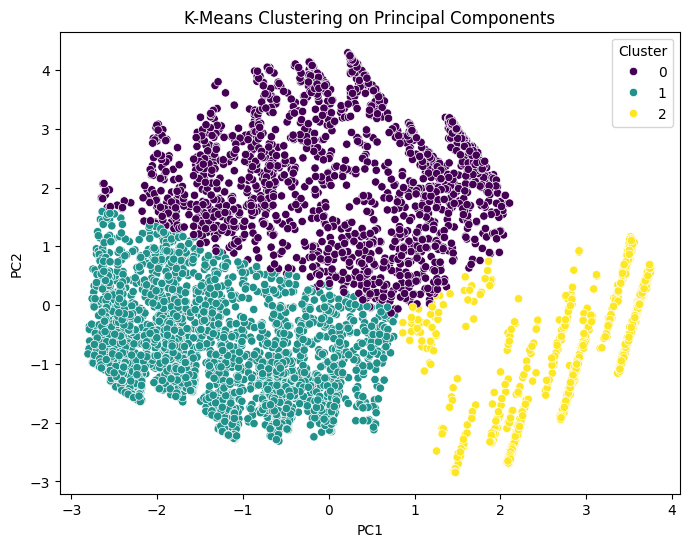

In [5]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Cargar los dataframes desde archivos CSV
dftrain = pd.read_csv('../data/train/train.csv')

# Seleccionar solo las variables predictoras, excluyendo la variable objetivo 'Churn'
X_train = dftrain[['Contract_Month-to-month', 'Contract_Two year', 'tenure', 'InternetService_Fiber optic',
                   'PaymentMethod_Electronic check', 'MonthlyCharges', 'OnlineSecurity',
                   'TechSupport', 'MultipleLines']]

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Aplicar K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

# Añadir las etiquetas de cluster al DataFrame original
dftrain['Cluster'] = kmeans.labels_

# Visualizar los clusters en dos componentes principales
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = kmeans.labels_

# Graficar los clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette='viridis')
plt.title('K-Means Clustering on Principal Components')
plt.show()

Cluster
0    0.097426
1    0.458410
2    0.074534
Name: Churn, dtype: float64


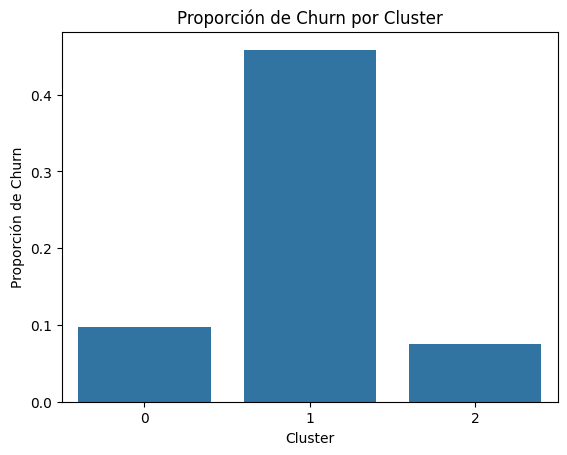

In [6]:
# Añadir la información de churn al DataFrame con los clusters
dftrain['Cluster'] = kmeans.labels_

# Calcular la proporción de churn en cada cluster
churn_by_cluster = dftrain.groupby('Cluster')['Churn'].mean()
print(churn_by_cluster)

# Visualizar la proporción de churn en cada cluster
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x=churn_by_cluster.index, y=churn_by_cluster.values)
plt.title('Proporción de Churn por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proporción de Churn')
plt.show()

### Generar Clusters con K-Means

In [10]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Cargar los dataframes desde archivos CSV
dftrain = pd.read_csv('../data/train/train.csv')
dftest = pd.read_csv('../data/test/test.csv')

# Separar variables predictoras y objetivo
X_train = dftrain[['Contract_Month-to-month', 'Contract_Two year', 'tenure', 'InternetService_Fiber optic',
                   'PaymentMethod_Electronic check', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity',
                   'TechSupport', 'MultipleLines']]
y_train = dftrain['Churn']

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Aplicar K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

# Añadir las etiquetas de cluster al DataFrame de entrenamiento
dftrain['Cluster'] = kmeans.labels_

# Hacer lo mismo para el conjunto de prueba
X_test = dftest[['Contract_Month-to-month', 'Contract_Two year', 'tenure', 'InternetService_Fiber optic',
                 'PaymentMethod_Electronic check', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity',
                 'TechSupport', 'MultipleLines']]
X_test_scaled = scaler.transform(X_test)
dftest['Cluster'] = kmeans.predict(X_test_scaled)
y_test = dftest['Churn']

In [9]:
# Entrenar Modelo Supervisado con Clusters
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Seleccionar las variables predictoras incluyendo el cluster
X_train_with_cluster = dftrain[['Contract_Month-to-month', 'Contract_Two year', 'tenure', 'InternetService_Fiber optic',
                                'PaymentMethod_Electronic check', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity',
                                'TechSupport', 'MultipleLines', 'Cluster']]

X_test_with_cluster = dftest[['Contract_Month-to-month', 'Contract_Two year', 'tenure', 'InternetService_Fiber optic',
                              'PaymentMethod_Electronic check', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity',
                              'TechSupport', 'MultipleLines', 'Cluster']]

# Definir el pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Entrenar el modelo
pipeline.fit(X_train_with_cluster, y_train)
y_pred = pipeline.predict(X_test_with_cluster)

# Evaluar el modelo
print("Logistic Regression with Clusters Accuracy:", accuracy_score(y_test, y_pred))
print("Logistic Regression with Clusters Classification Report:\n", classification_report(y_test, y_pred))

Logistic Regression with Clusters Accuracy: 0.7377398720682303
Logistic Regression with Clusters Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.74      0.80      1033
           1       0.50      0.74      0.60       374

    accuracy                           0.74      1407
   macro avg       0.70      0.74      0.70      1407
weighted avg       0.79      0.74      0.75      1407



### Normalizar

In [11]:
# Definir el pipeline 
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),  # Usar SMOTE para sobremuestrear
    ('scaler', StandardScaler()),  # Normalizar los datos
    ('pca', PCA()),  # Reducción de dimensionalidad opcional
    ('classifier', GradientBoostingClassifier())
])

In [25]:
# Predecir en el conjunto de prueba
y_pred = modelo_rf.predict(X_test)

In [26]:
# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.77
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1033
           1       0.60      0.46      0.52       374

    accuracy                           0.77      1407
   macro avg       0.71      0.67      0.69      1407
weighted avg       0.76      0.77      0.76      1407



### Random Forest

In [15]:
# Modelo Random Forest
modelo_rf = RandomForestClassifier(random_state=42)
modelo_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [16]:
# Predecir en el conjunto de prueba
y_pred = modelo_rf.predict(X_test)

In [17]:
# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.77
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1033
           1       0.60      0.46      0.52       374

    accuracy                           0.77      1407
   macro avg       0.71      0.67      0.69      1407
weighted avg       0.76      0.77      0.76      1407



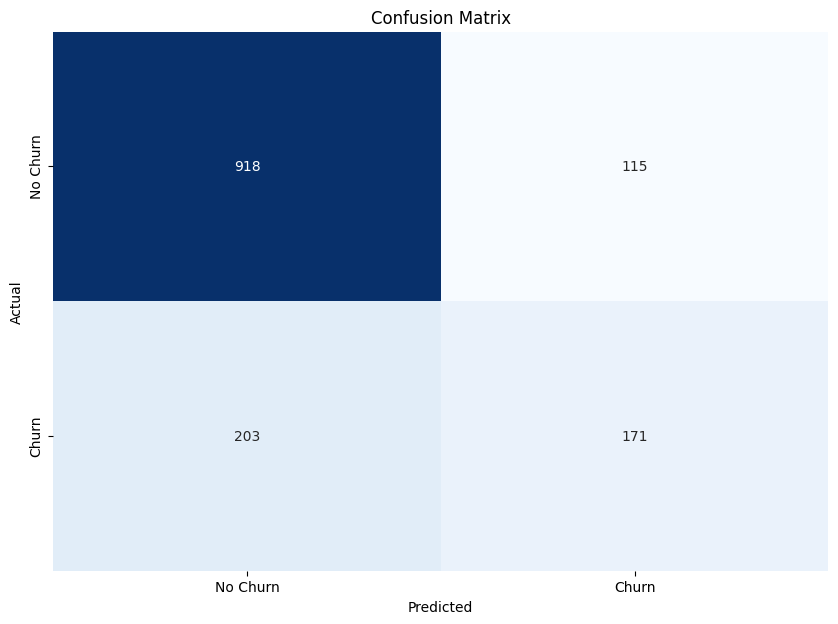

In [18]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Gradient Boosting Classifier

In [19]:
# Crear y entrenar el modelo Gradient Boosting
modelo_gb = GradientBoostingClassifier(random_state=42)
modelo_gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [20]:
# Predecir en el conjunto de prueba
y_pred = modelo_gb.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1033
           1       0.63      0.47      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.68      0.70      1407
weighted avg       0.77      0.79      0.77      1407



In [21]:
# Guardar el modelo utilizando pickle
with open('modelo_gradientboosting.pkl', 'wb') as f:
    pickle.dump(modelo_gb, f)

In [22]:
# Cargar el modelo guardado
with open('modelo_gradientboosting.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Verificar que el modelo cargado funciona correctamente
# Predecir
y_pred = loaded_model.predict(X_test)

# Evaluar la precisión del modelo cargado
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1033
           1       0.63      0.47      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.68      0.70      1407
weighted avg       0.77      0.79      0.77      1407



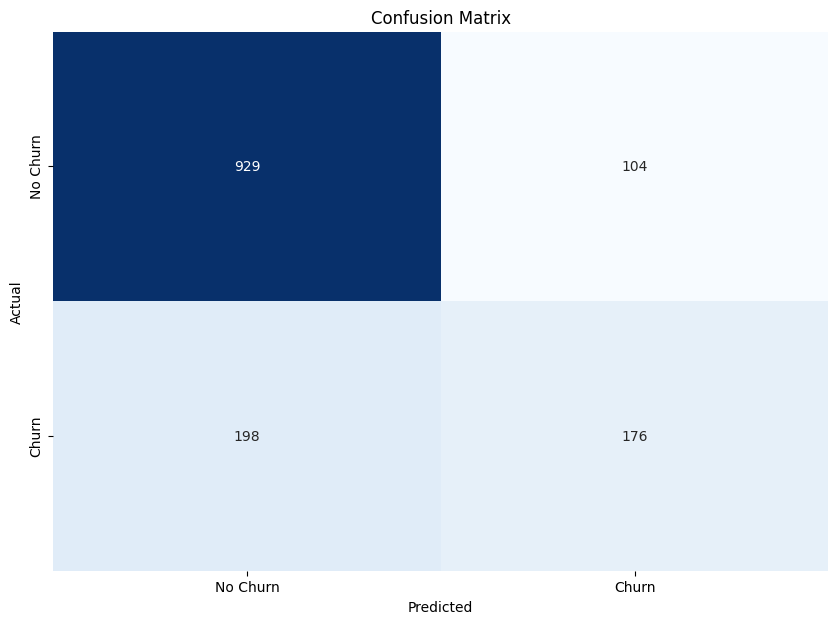

In [23]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### GridSearch para ajustar los hiperparámetros del modelo GradientBoostingClassifier 

In [ ]:
# Definir el modelo Gradient Boosting ESTE TARDA 20 MINUTOS >>>>XXXX>>>>  >>>>XXXX>>>  >>>XXXX>>>>>
modelo_gb = GradientBoostingClassifier(random_state=42)

# Definir los hiperparámetros para el GridSearch
'''
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Usar GridSearchCV para encontrar los mejores hiperparámetros
grid = GridSearchCV(modelo_gb, param_grid, scoring='recall', refit=True, verbose=2, cv=3)
grid.fit(X_train, y_train)
'''
# Con este modelo subo una decima la accuracy y la precision conservando la el recall
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6]
}

# Búsqueda de hiperparámetros
grid = GridSearchCV(modelo_gb, param_grid, scoring='recall', refit=True, verbose=2, cv=3)
grid.fit(X_train, y_train)

In [27]:
# Predecir en el conjunto de prueba con el mejor modelo
y_pred = grid.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.64      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.72      1407
weighted avg       0.78      0.79      0.79      1407



In [28]:
# Predecir en el conjunto de prueba con el mejor modelo
y_pred = grid.predict(X_test)

### Guardar Modelo GBC GRID en Pickle

In [30]:
# Guardar el mejor modelo encontrado por GridSearchCV en un archivo pickle
best_model = grid.best_estimator_

# Ruta del modelo
model_filename = 'models/other/grid_gbc.pkl'

# Guardar el modelo en un archivo pickle
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Modelo guardado en {model_filename}")

# Para cargar el modelo desde el archivo pickle
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Usar `loaded_model` para hacer predicciones
y_pred_loaded_model = loaded_model.predict(X_test)

# Evaluar el modelo cargado
accuracy_loaded_model = accuracy_score(y_test, y_pred_loaded_model)
print(f'Accuracy del modelo cargado: {accuracy_loaded_model:.2f}')

Modelo guardado en models/other/grid_gbc.pkl
Accuracy del modelo cargado: 0.79


# Comparativa Modelos

In [51]:
# Resultados
results = {
    'Model': ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'Logistic Regression', 'SVM', 'ANN'],
    'Accuracy': [0.73, 0.78, 0.78, 0.79, 0.78, 0.78],
    'Recall': [0.50, 0.46, 0.50, 0.52, 0.38, 0.35],
    'F1-Score': [0.50, 0.52, 0.54, 0.56, 0.48, 0.46]
}

# Convertir a DataFrame
df_results = pd.DataFrame(results)

/var/folders/mq/mnz2dh_90hx7l6l083kjws6w0000gn/T/ipykernel_21793/1256233017.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=df_results, palette='viridis')


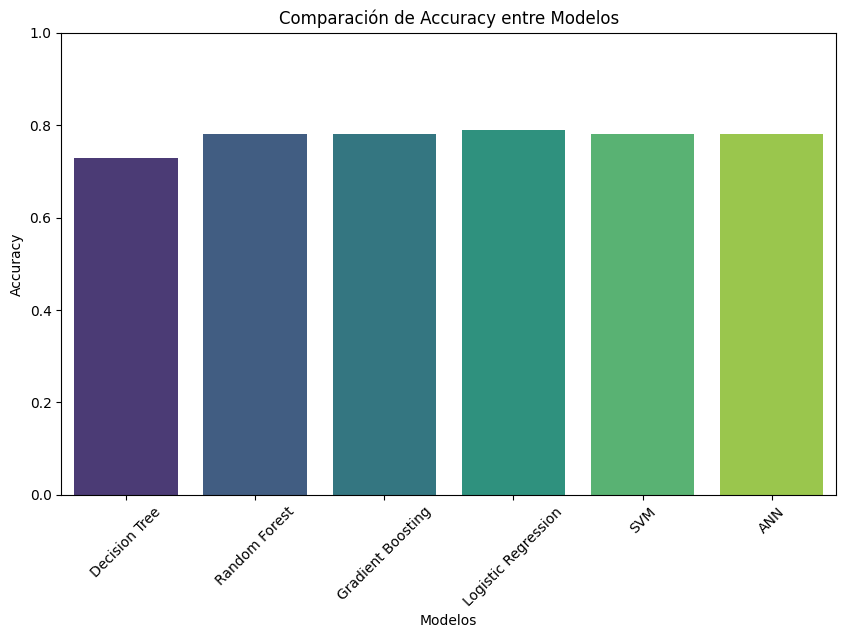

In [52]:
# Accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=df_results, palette='viridis')
plt.title('Comparación de Accuracy entre Modelos')
plt.xlabel('Modelos')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

/var/folders/mq/mnz2dh_90hx7l6l083kjws6w0000gn/T/ipykernel_21793/2785925666.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Recall', data=df_results, palette='viridis')


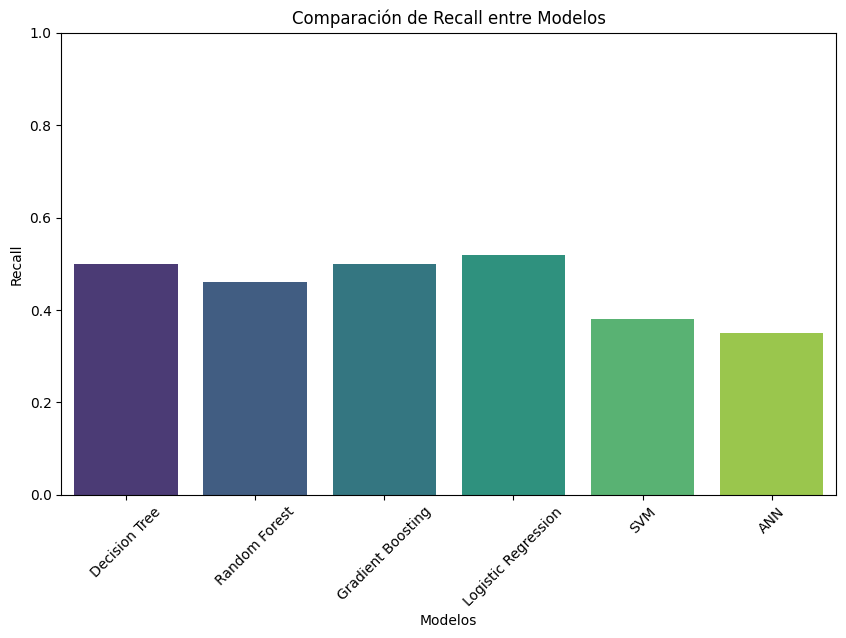

In [53]:
# Recall
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Recall', data=df_results, palette='viridis')
plt.title('Comparación de Recall entre Modelos')
plt.xlabel('Modelos')
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

/var/folders/mq/mnz2dh_90hx7l6l083kjws6w0000gn/T/ipykernel_21793/191619253.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1-Score', data=df_results, palette='viridis')


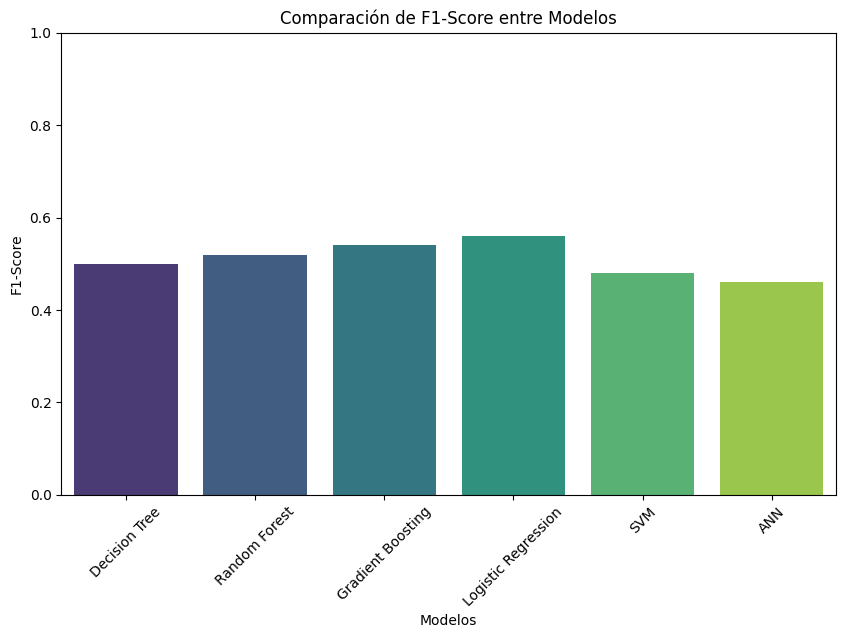

In [54]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='F1-Score', data=df_results, palette='viridis')
plt.title('Comparación de F1-Score entre Modelos')
plt.xlabel('Modelos')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

# Comparativa Modelos con Pipeline de Regularización y Balanceo

In [59]:
# Resultados Pipeline Regularizacion y Balanceo
results = {
    'Model N&B': ['Decision Tree N&B', 'Random Forest N&B', 'Gradient Boosting N&B', 'Logistic Regression N&B', 'SVM N&B', 'ANN N&B'],
    'Accuracy': [0.72, 0.75, 0.75, 0.69, 0.75, 0.76],
    'Recall': [0.57, 0.58, 0.63, 0.83, 0.70, 0.66],
    'F1-Score': [0.52, 0.55, 0.57, 0.58, 0.60, 0.59]
}

# Convertir a DataFrame
df_results = pd.DataFrame(results)

/var/folders/mq/mnz2dh_90hx7l6l083kjws6w0000gn/T/ipykernel_21793/4216747033.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model N&B', y='Accuracy', data=df_results, palette='viridis')


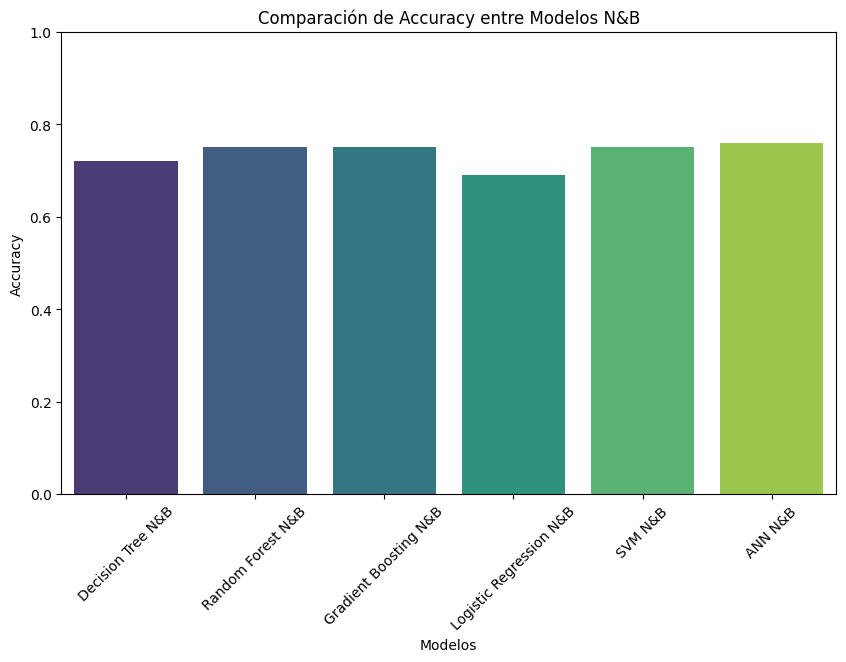

In [65]:
# Accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x='Model N&B', y='Accuracy', data=df_results, palette='viridis')
plt.title('Comparación de Accuracy entre Modelos N&B')
plt.xlabel('Modelos')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

/var/folders/mq/mnz2dh_90hx7l6l083kjws6w0000gn/T/ipykernel_21793/1430488923.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model N&B', y='Recall', data=df_results, palette='viridis')


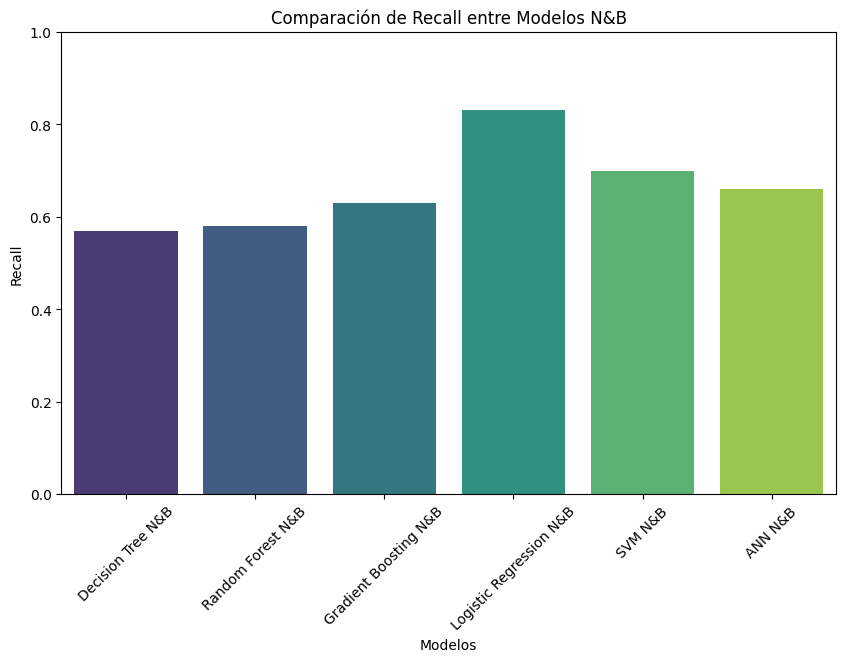

In [66]:
# Recall
plt.figure(figsize=(10, 6))
sns.barplot(x='Model N&B', y='Recall', data=df_results, palette='viridis')
plt.title('Comparación de Recall entre Modelos N&B')
plt.xlabel('Modelos')
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

/var/folders/mq/mnz2dh_90hx7l6l083kjws6w0000gn/T/ipykernel_21793/2008591691.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model N&B', y='F1-Score', data=df_results, palette='viridis')


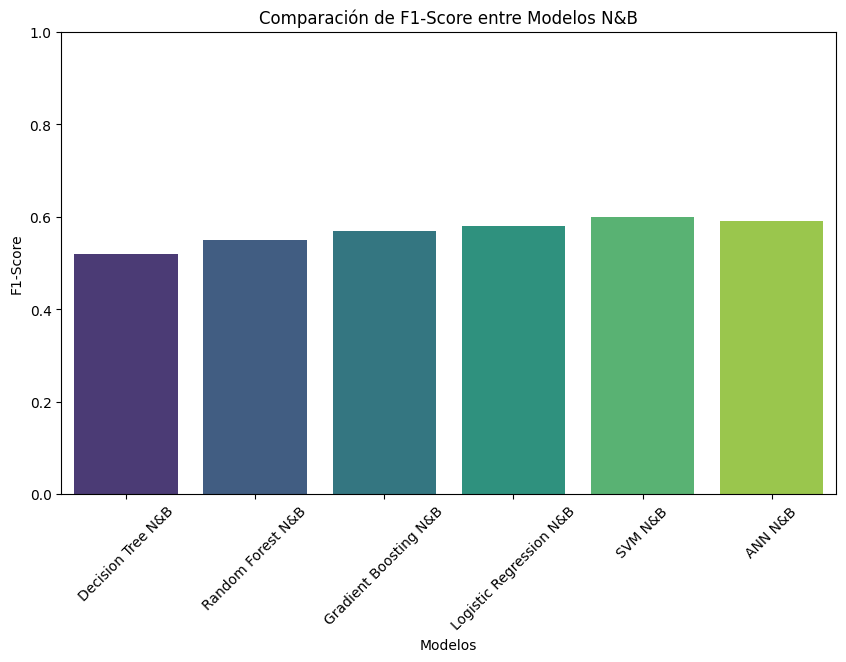

In [67]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model N&B', y='F1-Score', data=df_results, palette='viridis')
plt.title('Comparación de F1-Score entre Modelos N&B')
plt.xlabel('Modelos')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

# CARGAR MODELO FINAL

In [ ]:
# Cargar el modelo desde el archivo pickle
with open('../models/best_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

# Usar el modelo cargado para predecir
new_predictions = loaded_model.predict(X_test)

print("New Predictions Accuracy:", accuracy_score(y_test, new_predictions))
print("New Predictions Classification Report:\n", classification_report(y_test, new_predictions))

In [ ]:
# Probar con un usuario
with open('../models/best_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
y_pred = loaded_model.predict(X_test[0:1])